**Name:** YANG Yongze

**EID:** 58162280

# CS5489 - Tutorial 5
## Predicting Bike Sharing Usage

In this tutorial you will train a regression function to predict the number people using bike sharing in each day.

First we need to initialize Python.  Run the below cell.

In [21]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats

## Loading Data and Pre-processing
Next we need to load the data.  Download `Bike-Sharing-Dataset.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [3]:
# read the data
filename = 'Bike-Sharing-Dataset/day.csv'
df = pd.read_csv(filename)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Here are the columns in the dataset. The last 3 columns are the counts for the day.

In [4]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

The first two columns are the instance number and date, which aren't useful, so we will remove them.

In [5]:
# remove first 2 columns
df.drop(columns=['instant', 'dteday'], inplace=True)

Next we will examine the distribution of the features.

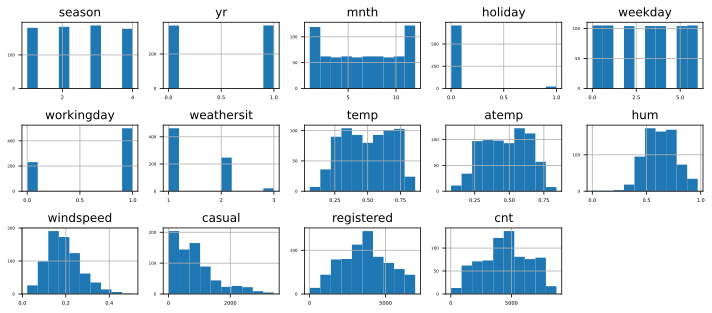

In [6]:
# show the feature distributions
foo = df.hist(layout=(14,5), figsize=(10,20), xlabelsize=5, ylabelsize=4)
plt.tight_layout()

And here are some simple statistics of the features.

In [7]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


You may notice that a few of the features are discrete values, such as `season`, `mnth`, `weekday`, and `weathersit`.  If we directly use the month feature, it may not make too much sense since adding/subtracting/multipllying 2 month numbers doesn't really mean anything related to the output. Instead, it is important which month it is.

Thus, we will convert these features into one-hot-encodings.  The original discrete features are removed, and the new features are appended to the end of the table.

In [8]:
# use pandas to create one-hot-encodings of a few colummns
dfd = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'])
dfd

,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,...,0,0,0,0,1,0,0,0,1,0
727,1,0,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,...,0,0,0,0,0,1,0,0,1,0
728,1,0,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,...,0,0,0,0,0,0,1,0,1,0
729,1,0,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,...,1,0,0,0,0,0,0,1,0,0


Now we extract the data for running our regression algorithm. First we remove the counts to get the input features X.

In [9]:
# extract the features
dfX = dfd.drop(columns=['casual', 'registered', 'cnt'])
dataX = array(dfX)
dataX.shape

(731, 33)

In [10]:
# get the feature names
featnames = [x.strip() for x in dfX.columns]
print(featnames)

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']


Next we use the total count as the target Y.

In [11]:
# get the target count
dataY = array(dfd['cnt'])
dataY.shape

(731,)

Finally, we extract the year number, which we will use for setting up the training/testing data later.

In [12]:
# get the year number (used for splitting the data into training/testing)
dataYear = array(dfd['yr'])
dataYear.shape

(731,)

Here is an example input/output for our problem.

In [13]:
print(featnames)

print("--- example features---")
print(dataX[0])
print("--- example target count")
print(dataY[0])

['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']
--- example features---
[0.       0.       0.       0.344167 0.363625 0.805833 0.160446 1.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       1.       0.       1.
 0.      ]
--- example target count
985


Now we separate the data into training and testing sets.  Since our data is collected over time, it is better to separate the training and test data so that they don't overlap in time. This way, we can ensure that our method generalizes to newly collected data.

We will use the first year for training, and the second year for testing.

In [15]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
# use 2nd year as testing data
testX  = dataX[dataYear==1]
testY  = dataY[dataYear==1]

print(trainX.shape)
print(testX.shape)

(365, 33)
(366, 33)


Note that the input features are already normalized between 0 and 1 (or are binary values), so we don't need to perform feature normalization.

### Dummy regressor
We next test a "dummy" regressor that simply predicts the mean or median output value.  These are useful to evaluate the regression methods to see how much better they are than simply predicting the same value.

In [14]:
# dummy regressors that predict constant values
dummy_mean = dummy.DummyRegressor(strategy='mean')
dummy_mean.fit(trainX, trainY)
dummy_med  = dummy.DummyRegressor(strategy='median')
dummy_med.fit(trainX, trainY)

DummyRegressor(strategy='median')

Next we evaluate the regressor using MSE and MAE.

In [16]:
# function to evaluate root mean squared error (MSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [16]:
# place to store our regression results
trainerr={}; testerr={}

trainerr['dummy_mean'] = eval_predict(trainY, dummy_mean.predict(trainX))
testerr['dummy_mean']  = eval_predict(testY, dummy_mean.predict(testX))
trainerr['dummy_med']  = eval_predict(trainY, dummy_med.predict(trainX))
testerr['dummy_med']   = eval_predict(testY, dummy_med.predict(testX))

print("dummy-mean: train (RMSE,MAE)=", trainerr['dummy_mean'] )
print("dummy-mean: test  (RMSE,MAE)=", testerr['dummy_mean']  )
print("dummy-med:  train (RMSE,MAE)=", trainerr['dummy_med']  )
print("dummy-med:  test  (RMSE,MAE)=", testerr['dummy_med']   )

dummy-mean: train (RMSE,MAE)= (1376.8636667749531, 1197.7539801088385)
dummy-mean: test  (RMSE,MAE)= (2829.3083242385123, 2488.6733587843405)
dummy-med:  train (RMSE,MAE)= (1416.8517338156587, 1172.8849315068494)
dummy-med:  test  (RMSE,MAE)= (2578.749205425156, 2260.841530054645)


Finally, we can visualize the quality of the prediction result by using a scatter plot of truth vs. prediction.  Since we are using a "dummy" predictor, the x-value predictions are constant.  The red line shows the ideal regressor where all the predictions are equal to the true values.

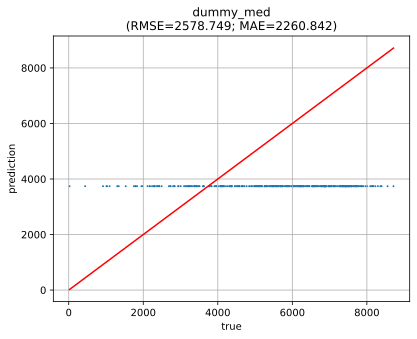

In [17]:
plot_scatter(testY, dummy_med.predict(testX), 'dummy_med')

## Prediction with Linear Regression

First we will look at predicting the count using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [18]:
### INSERT YOUR CODE HERE

In [19]:
# Ordinary Least Squares

ols = linear_model.LinearRegression()
ols.fit(trainX,trainY)

LinearRegression()

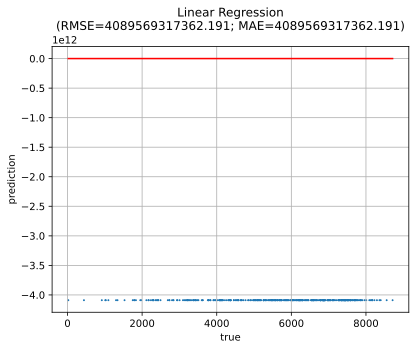

In [20]:
plot_scatter(testY,ols.predict(testX),'Linear Regression')

In [21]:
alphas = logspace(-3,6,50)

rr = linear_model.RidgeCV(alphas = alphas, cv = 5)
rr.fit(trainX,trainY)


print('alpha = ',rr.alpha_)
print('w = ', rr.coef_)

alpha =  0.1599858719606059
w =  [    0.          -243.6031091    127.0237448   1854.58337656
  1195.06609252 -1209.635737   -1740.78978726  -620.68283229
  -170.51654586   245.16766532   546.03171283  -748.37669998
  -567.03455874  -394.20370881   127.19672294   893.2797856
   638.62693385  -113.48075218     4.4866818    420.74162739
   212.82273929  -208.95057534  -265.10819581   -11.78373632
   -35.53288391     6.88462519   -37.41222018   -60.61241655
    10.09353115   128.36310062   647.0561676    339.58376981
  -986.6399374 ]


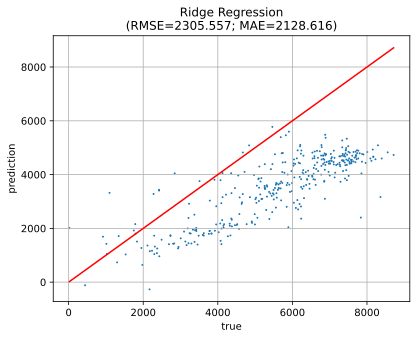

In [22]:
plot_scatter(testY,rr.predict(testX),'Ridge Regression')

Compare the two models using the RMSE and MAE between the predictions and the true values.  Below is  code that will calculate evaluation for the training and test sets.

In [23]:
# ols is the linear regression model
trainerr['ols'] = eval_predict(trainY, ols.predict(trainX))
testerr['ols']  = eval_predict(testY, ols.predict(testX))
print("OLS: train MSE,MAE =", trainerr['ols'])
print("OLS: test  MSE,MAE =", testerr['ols'])

# rr is the ridge regression model
trainerr['rr'] = eval_predict(trainY, rr.predict(trainX))
testerr['rr']  = eval_predict(testY, rr.predict(testX))
print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])

OLS: train MSE,MAE = (552.8169381660512, 413.93150684931504)
OLS: test  MSE,MAE = (4089569317362.1914, 4089569317362.1914)
RR: train MSE,MAE = (549.9374320904267, 407.29830510137884)
RR: test  MSE,MAE = (2305.557150484269, 2128.6157901270585)


Which model has better prediction ability on the test set? Why?
- Based on the MSE and MAE of training and testing, RR's model performs better. This may be due to the fact that ridge regression enhances the generalization ability of the model by introducing the L2 regular term to prevent overfitting.

Finally, we look at the scatter plot for ridge-regression.

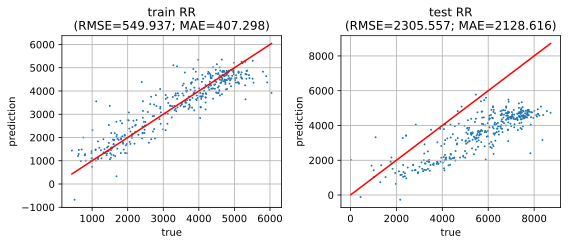

In [24]:
# rr is the ridge regression model
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rr.predict(trainX), "train RR")
plt.subplot(1,2,2)
plot_scatter(testY, rr.predict(testX), "test RR")
plt.tight_layout()

Do you notice anything interesting about the test predictions?  We'll see how to solve this problem later.

- In all regressors, in the test set, they predicted higher data than the actual values.

# Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [25]:
### INSERT YOUR CODE HERE

In [26]:
las = linear_model.LassoCV()
las.fit(trainX, trainY)

print('MSE = ' , metrics.mean_squared_error(testY, las.predict(testX)))
print('alpha = ', las.alpha_)
print('w = ', las.coef_)

MSE =  5397009.07312867
alpha =  3.729639752507565
w =  [    0.          -169.15011638    62.87031977  3017.21771389
     0.          -734.1885162  -1130.77540609 -1008.43902026
  -232.66547492    36.89731181   208.32423345  -419.4767226
  -253.67744401  -200.79924401     0.           732.6360563
   560.94881986   -17.12331785     0.           417.0832476
   348.61599574    -0.            -0.            -9.57435203
    -0.            23.15635888    -0.            -0.
    37.36474301    82.59011455   372.58080197    -0.
 -1337.87067502]


Examine the LASSO coefficients by sorting them in descending order.

In [27]:
# las is the trained LASSO model
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(las.coef_))[::-1]
# print out
print("weight : feature description")
for i in inds:
    print("{: .3f} : {}".format(las.coef_[i], featnames[i]))
print("bias = ", las.intercept_)

weight : feature description
 3017.218 : temp
-1337.871 : weathersit_3
-1130.775 : windspeed
-1008.439 : season_1
-734.189 : hum
 732.636 : mnth_5
 560.949 : mnth_6
-419.477 : mnth_1
 417.083 : mnth_9
 372.581 : weathersit_1
 348.616 : mnth_10
-253.677 : mnth_2
-232.665 : season_2
 208.324 : season_4
-200.799 : mnth_3
-169.150 : holiday
 82.590 : weekday_6
 62.870 : workingday
 37.365 : weekday_5
 36.897 : season_3
 23.156 : weekday_2
-17.123 : mnth_7
-9.574 : weekday_0
-0.000 : weekday_1
 0.000 : mnth_4
-0.000 : weekday_3
-0.000 : weathersit_2
-0.000 : weekday_4
 0.000 : mnth_8
 0.000 : atemp
-0.000 : mnth_11
-0.000 : mnth_12
 0.000 : yr
bias =  2541.379375849472


_Which features have largest affect on the predicted bike share count, and what is the interpretation?_

Note that the features are normalized between 0 and 1 (or are binary values), so the weights corresponding to increase/decrease of bike count.  The bias term corresponds to the typical number of bikes used, which is modified based on the features.
- The biggest influence is temperature, and it's factually correct that the warmer it is, the more likely people are to use bike share to get around.
- Additionally, slight severe weather(weather_3), high wind speeds(windspeed), spring(season 1), and humidity will affect people's willingness to use bike share, which may explain why these characteristics have the highest negative WEIGHT.

Now try feature selection using OMP.  You can try the top 10 features.

In [28]:
### INSERT YOUR CODE HERE

In [29]:
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10, normalize=False)
omp.fit(trainX, trainY)

print('MSE = ' , metrics.mean_squared_error(testY, omp.predict(testX)))

MSE =  5522244.40061597


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [30]:
print("weight : feature description")
for i in inds:
    if omp.coef_[i] != 0:
        print("{: .3f} : {}".format(omp.coef_[i], featnames[i]))
print("bias = ", omp.intercept_)

weight : feature description
 3214.272 : temp
-780.259 : season_1
 855.331 : mnth_5
 718.328 : mnth_6
-212.365 : mnth_1
 412.039 : mnth_9
 2036.561 : weathersit_1
 739.020 : season_4
 372.515 : season_3
 1544.453 : weathersit_2
bias =  -175.45407122752567


Do you get similar selected features? Why or why not?
- The weights chosen for these two models are roughly the same, but there are some minor differences.For temp, both models have the highest positive weights in both.
- For season_1, or winter, both models give relatively large negative weights, but OMP gives smaller weights.
- For the months of May, June, and September, both models give positive weights, but with different values.
- For weather conditions 1 and 2, they appear in both models only in OMP, indicating that OMP puts more weight on the effect of weather on sharing bikes.
- For wind speed, humidity, and weather condition 3 (slight severe weather), these three features only appear in LASSO.

# Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  Use cross-validation on the training set to select the parameters. 

In [ ]:
### INSERT YOUR CODE HERE

In [31]:
# Kernel Ridge Regression
paramgrid = {
    'gamma': logspace(-3,3,10),
    'alpha': logspace(-3,3,10)
}

krrcv = model_selection.GridSearchCV(
    kernel_ridge.KernelRidge(kernel = 'rbf'),
    param_grid=paramgrid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    n_jobs = -1,
    verbose = False
)

krrcv.fit(trainX, trainY)

print('Best score: ', krrcv.best_score_)
print('Best params: ', krrcv.best_params_)


Best score:  -674119.8675446851
Best params:  {'alpha': 0.001, 'gamma': 0.001}


In [32]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# Gaussian Process Regression
kernels = [ DotProduct() + RBF() + WhiteKernel(),
            DotProduct()**2 + RBF() + WhiteKernel(),
            DotProduct()**3 + RBF() + WhiteKernel(),
            RBF(length_scale=0.01) + RBF() + WhiteKernel(),
            DotProduct()**2 + WhiteKernel(),
            RBF() + WhiteKernel()]
kernel_names = ['linear+rbf', 'poly2+rbf', 'poly3+rbf', 'rbf+rbf','poly2','rbf']

err = float('inf')
kernel_name = ''
for i,k in enumerate(kernels):
    gprcv = gaussian_process.GaussianProcessRegressor(kernel=k,
                                              random_state=5489,
                                              n_restarts_optimizer=5, 
                                              normalize_y=True)
    gprcv.fit(trainX, trainY)
    err_temp = metrics.mean_squared_error(testY, gprcv.predict(testX))
    if abs(err_temp) < err:
        err = err_temp
        kernel_name = kernel_names[i]

print('Best score: ', err)
print('Best kernel: ', kernel_name)
    

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__kernel__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best score:  4932964.691599639
Best kernel:  poly2


In [33]:
# Kernel Support Vector Regression
paramgrid = {
    'gamma': logspace(-2,2,10),
    'C': array([1,10,50,100,200,300,500,750,1000]),
    'epsilon': array([0.01,0.02,0.05,0.1,0.2,0.5,1,10]),
    'kernel':['poly','rbf']
}

svrcv = model_selection.GridSearchCV(
    svm.SVR(),
    param_grid = paramgrid,
    scoring = 'neg_mean_squared_error',
    n_jobs=-1,
    verbose=False,
    cv=5
)

svrcv.fit(trainX,trainY)

print('Best score: ', svrcv.best_score_)
print('Best params: ', svrcv.best_params_)

Best score:  -990991.2237955475
Best params:  {'C': 1000, 'epsilon': 0.01, 'gamma': 0.0774263682681127, 'kernel': 'rbf'}


In [34]:
# Random Forest Regressor
paramgrid = {
    'n_estimators': array([1,3,5,8,10,15,20,50,100,150,200,250,500,1000]),
    'max_depth': array([1,2,3,4,5,6,7,8,9,10,12,15])
}

rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(random_state=4487),
    param_grid = paramgrid,
    scoring = 'neg_mean_squared_error',
    n_jobs=-1,
    verbose=False,
    cv=5
)

rfcv.fit(trainX,trainY)

print('Best score: ', rfcv.best_score_)
print('Best params: ', rfcv.best_params_)

Best score:  -591465.3074999192
Best params:  {'max_depth': 12, 'n_estimators': 10}


In [35]:
# XGBoost Regression
paramsampler = {
"colsample_bytree": stats.uniform(0.2, 0.8), 
"gamma": stats.uniform(0, 1), 
"max_depth": stats.randint(0, 10), 
"subsample": stats.uniform(0.2, 1.0), 
"learning_rate": stats.uniform(.001,1),
"n_estimators": stats.randint(10, 1000),
}

xr = xgb.XGBRegressor(objective='reg:squarederror', random_state=4487)

xgbrcv = model_selection.RandomizedSearchCV(xr, 
                                      param_distributions=paramsampler, 
                                      cv=5, 
                                      scoring='neg_mean_squared_error', 
                                      verbose=0, 
                                      n_jobs=-1)

xgbrcv.fit(trainX,trainY)

print('Best score: ', xgbrcv.best_score_)
print('Best params: ', xgbrcv.best_params_)


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yangyongze/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/yangyongze/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py", line 1086, in fit
    self._Booster = trai

Best score:  -459698.2652575394
Best params:  {'colsample_bytree': 0.8297848443892044, 'gamma': 0.9234605058445833, 'learning_rate': 0.09048990170472848, 'max_depth': 8, 'n_estimators': 708, 'subsample': 0.24652716766613864}


Make a scatter plot of the best regressor. Call it `bestr`.

In [36]:
bestr = rfcv

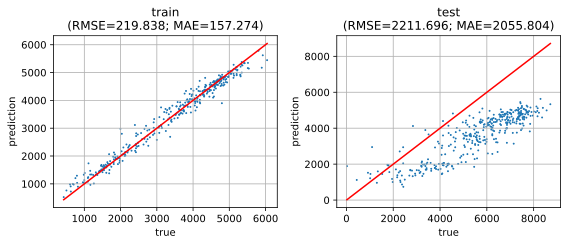

In [38]:
# scatter plot of the best regressor (bestr)
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, bestr.predict(trainX), "train")
plt.subplot(1,2,2)
plot_scatter(testY, bestr.predict(testX), "test")
plt.tight_layout()

_Which regression method performs the best? Why do you think so?_
- It is obviously that RandomForestRegressor works best due to the fact that its mean_squared_error has the smallest absolute value among all regressors.

# Test set bias

In your scatter plot above, you may have noticed that the regressor is almost always under-predicting the count (the points are usually below the red line). This suggests that there is some bias in the test set.

Let's look at the plot of the count over time.  The left side is the training data (1st year), and the right side is the testing data (2nd year)

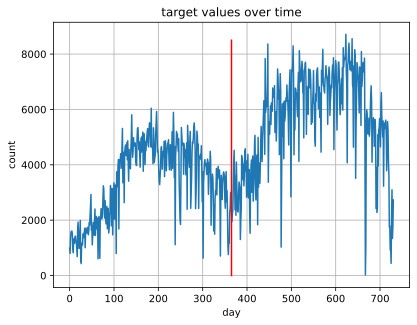

In [17]:
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

Interestingly, it looks like bike sharing became more popular in the 2nd year, so the overall counts are higher (but the seasonal trend looks the same).

Let's assume that we noticed this upward trend in the first 3 months of the year, and collected the data for training.  We will then use the remaining part of the 2nd year for testing.

In [18]:
# get indices for month 1 to month 3
print(featnames[11], featnames[12], featnames[13])
inds = (testX[:,11].ravel()==1) + (testX[:,12].ravel()==1) + (testX[:,13].ravel()==1)

# new training data from 2nd year (months 1-3)
trainX2 = testX[inds]
trainY2  = testY[inds]
# new testing data from 2nd year (months 4-12)
testX2  = testX[logical_not(inds)]
testY2   = testY[logical_not(inds)]
print(trainX2.shape)
print(testX2.shape)

mnth_1 mnth_2 mnth_3
(91, 33)
(275, 33)


There are several approaches for using the new data:
1. use the new data to train the regressor, and ignore the old data.
2. append the new data with the old data and train a regressor.  Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.
3. use the new data to train a regressor on the residual error of the old regressor.  The residual error is the difference between the predicted count and true count on the new training data.

Using **one selected** regression method, try each of the approaches above to use the new data. You should compare the 3 approaches with the regressor trained on the original data and tested on the new test set (`testY2`).

In [19]:
# append new data with old data
trainY2_append = concatenate((trainY, trainY2), axis=0)
trainX2_append = concatenate((trainX, trainX2), axis=0)
print(trainY2_append.shape)
print(trainX2_append.shape)

(456,)
(456, 33)


In [18]:
### INSERT YOUR CODE HERE

In [20]:
def plot_compare(trX, trY, teX, teY, bestr):
    plt.figure(figsize=(8,3.5))
    plt.subplot(1,2,1)
    plot_scatter(trY, bestr.predict(trX), "train")
    plt.subplot(1,2,2)
    plot_scatter(teY, bestr.predict(teX), "test")
    plt.tight_layout()

In [20]:
# Method 1
paramgrid = {
    'n_estimators': array([1,3,5,8,10,15,20,50,100,150,200,250,500,1000]),
    'max_depth': array([1,2,3,4,5,6,7,8,9,10,12,15])
}

rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(random_state=4487),
    param_grid = paramgrid,
    scoring = 'neg_mean_squared_error',
    n_jobs=-1,
    verbose=False,
    cv=5
)

rfcv.fit(trainX2,trainY2)

print('Best score: ', rfcv.best_score_)
print('Best params: ', rfcv.best_params_)


Best score:  -1010577.7827829961
Best params:  {'max_depth': 8, 'n_estimators': 10}


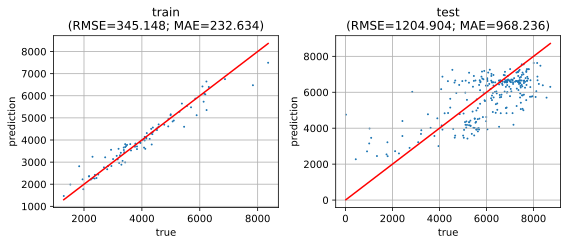

In [23]:
plot_compare(trainX2,trainY2,testX2,testY2,rfcv)

In [24]:
# Method 2
paramgrid = {
    'n_estimators': array([1,3,5,8,10,15,20,50,100,150,200,250,500,1000]),
    'max_depth': array([1,2,3,4,5,6,7,8,9,10,12,15])
}

rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(random_state=4487),
    param_grid = paramgrid,
    scoring = 'neg_mean_squared_error',
    n_jobs=-1,
    verbose=False,
    cv=5
)

rfcv.fit(trainX2_append,trainY2_append)

print('Best score: ', rfcv.best_score_)
print('Best params: ', rfcv.best_params_)

Best score:  -1604791.812770162
Best params:  {'max_depth': 9, 'n_estimators': 100}


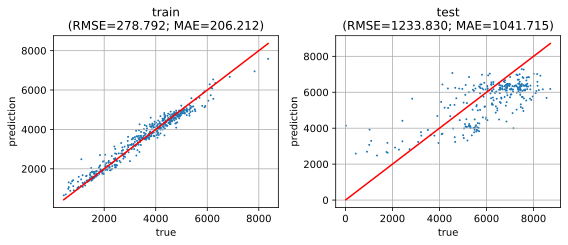

In [25]:
plot_compare(trainX2_append,trainY2_append,testX2,testY2,rfcv)

In [31]:
# Method 3: Use the new data to train a regressor on the residual error of the old regressor.
# The residual error is the difference between the predicted count and true count on the new training data.

(91,)
(91,)
(275,)


In [24]:
# old regressor
rfcv_old = ensemble.RandomForestRegressor(random_state=4487,
                                          n_estimators=100,
                                          max_depth=9)
rfcv_old.fit(trainX, trainY)

predY2 = rfcv_old.predict(trainX2)
residual_error = trainY2 - predY2
test_predY = rfcv_old.predict(testX2)



In [26]:
# Train a new regressor on the residual error
paramgrid = {
    'n_estimators': array([1,3,5,8,10,15,20,50,100,150,200,250,500,1000]),
    'max_depth': array([1,2,3,4,5,6,7,8,9,10,12,15])
}

rfcv_res = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(random_state=4487),
    param_grid = paramgrid,
    scoring = 'neg_mean_squared_error',
    n_jobs=-1,
    verbose=False,
    cv=5
)

rfcv_res.fit(trainX2, residual_error)

test_residual_error = rfcv_res.predict(testX2)
corrected_test_predY = test_predY + test_residual_error

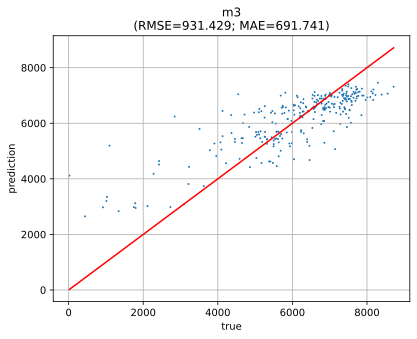

In [27]:
plot_scatter(testY2, corrected_test_predY, 'method 3')

_Which approach for using the new data is better? Explain why you think the other approaches don't work well._
- Obviously, the third method has the lowest MAE and RMSE on the test dataset and the prediction is close to the actual data. This may be due to the fact that this method not only utilizes the original data, but also learns new data errors to improve the original data, adapts to changes in the data, and reduces the possibility of overfitting.
- The first method trains only the new data and ignores the old data, which may lead to overfitting and may be under-trained due to the small amount of data.
- The second method may not work well in the new data due to the different distribution of the old and new data and the small amount of new data input, so the model may be more influenced by the old data.